# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups               
Sample_012  P63104                          17.468
Sample_206  A0A0A0MTP9;F8VZI9;Q9BWQ8        17.154
Sample_015  B5MCX6;F8W8J5;Q8TAG5;Q8TAG5-2   20.713
Sample_021  A0A182DWH7;P49908               19.555
Sample_193  P47972                          17.540
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                                                               
Sample_029  A0A0U1RR32;A0A0U1RRH7;P04908;P0C0S8;P20671;Q7L7L0;Q93077;Q96KK5;Q99878;Q9BTM1   15.664
Sample_198  Q13433                                                                          13.485
Sample_146  A0A0C4DGV4;E9PLX3;O43504;R4GMU8                                                 14.073
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.969
            A0A075B6Q5                 12.268
            A0A075B6R2                 12.569
            A0A075B6S5                 11.976
            A0A087WSY4                 13.510
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.032
            Q9UI40;Q9UI40-2            13.983
            Q9UIW2                     12.306
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.132
            Q9UP79                     12.942
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.068,15.050,16.842,19.863,16.035,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.690,19.067,...,15.528,15.576,13.906,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.829,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.912,17.705,17.039,15.550,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.645,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.758,15.345,17.084,18.708,14.249,19.433,11.480,10.635
Sample_207,15.739,16.877,15.469,16.898,13.637,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.513,12.224,13.535,13.607,12.651,14.101,13.383,11.931,13.247,12.901
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.708,19.067,16.127,...,12.116,14.099,12.742,12.921,13.198,12.154,11.950,12.197,11.162,12.501
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,14.177,13.666,12.684,13.390,13.484,12.055,13.391,11.221,12.513,12.576
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.874,14.103,13.097,12.730,11.702,12.910,12.919,12.649,13.184,12.347
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.432,12.919,12.676,11.561,12.467,13.240,12.983,12.045,11.844,12.968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.046,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 108.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.48it/s]

100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.33it/s]

100%|██████████| 4/4 [00:00<00:00,  4.04it/s]

100%|██████████| 4/4 [00:00<00:00,  4.22it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.88it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.96it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.82it/s]

100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.33it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.77it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.48it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

100%|██████████| 6/6 [00:01<00:00,  4.39it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.82it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.17it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.11it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.59it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.52it/s]

100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.49it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.40it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.79it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.68it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.56it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.55it/s]

100%|██████████| 8/8 [00:02<00:00,  2.72it/s]

100%|██████████| 8/8 [00:02<00:00,  2.81it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.48it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.90it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.16it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.31it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.51it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.21it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.01it/s]

100%|██████████| 9/9 [00:03<00:00,  1.91it/s]

100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.40it/s]

 30%|███       | 3/10 [00:00<00:01,  4.38it/s]

 40%|████      | 4/10 [00:00<00:01,  4.10it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.14it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.19it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.98it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.01it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.17it/s]

100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.46it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.03it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.70it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.38it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.43it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.37it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.20it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.23it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.22it/s]

100%|██████████| 11/11 [00:02<00:00,  4.23it/s]

100%|██████████| 11/11 [00:02<00:00,  4.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.43it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.84it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.69it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.37it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.78it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.60it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.40it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.31it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.34it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.82it/s]

100%|██████████| 12/12 [00:02<00:00,  3.93it/s]

100%|██████████| 12/12 [00:02<00:00,  4.41it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.27it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.12it/s]

 31%|███       | 4/13 [00:00<00:01,  5.44it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.06it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.81it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.70it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.66it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.58it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.14it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.08it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.03it/s]

100%|██████████| 13/13 [00:02<00:00,  4.17it/s]

100%|██████████| 13/13 [00:02<00:00,  4.60it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.60it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.34it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.54it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.41it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.31it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.19it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.21it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.69it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.76it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.66it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.89it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.02it/s]

100%|██████████| 14/14 [00:03<00:00,  4.00it/s]

100%|██████████| 14/14 [00:03<00:00,  4.16it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.91it/s]

 20%|██        | 3/15 [00:00<00:02,  5.96it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.01it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.72it/s]

 40%|████      | 6/15 [00:01<00:01,  4.59it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.29it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.15it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.62it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.59it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.62it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.80it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.92it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.02it/s]

100%|██████████| 15/15 [00:03<00:00,  4.12it/s]

100%|██████████| 15/15 [00:03<00:00,  4.21it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.042 0.010          0.690 0.405       0.089   
2             0.006 0.003      0.052 0.019          0.705 0.108       0.520   
3             0.005 0.002      0.064 0.024          0.758 0.077       0.714   
4             0.004 0.001      0.040 0.007          0.742 0.066       0.715   
5             0.005 0.002      0.052 0.019          0.767 0.079       0.733   
6             0.006 0.003      0.057 0.024          0.796 0.087       0.825   
7             0.004 0.002      0.045 0.014          0.789 0.088       0.817   
8             0.006 0.004      0.062 0.035          0.803 0.092       0.832   
9             0.007 0.004      0.068 0.035          0.802 0.090       0.833   
10            0.004 0.001      0.039 0.008          0.823 0.071       0.831   
11            0.004 0.001      0.037 0.008          0.818 0.076       0.827   
12            0.004 0.000      0.039 0.005          0.819 0.078       0.817   
13            0.004 0.001      0.037 0.008          0.823 0.081       0.820   
14            0.004 0.001      0.040 0.006          0.812 0.081       0.815   
15            0.004 0.001      0.039 0.004          0.809 0.085       0.808   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.079   0.152 0.121                  0.538 0.038        0.848   
2          0.108   0.592 0.093                  0.679 0.062        0.730   
3          0.099   0.731 0.071                  0.773 0.058        0.834   
4          0.094   0.724 0.062                  0.766 0.049        0.828   
5          0.102   0.745 0.073                  0.784 0.058        0.845   
6          0.100   0.807 0.077                  0.834 0.066        0.887   
7          0.101   0.799 0.077                  0.828 0.066        0.887   
8          0.086   0.813 0.068                  0.839 0.059        0.894   
9          0.090   0.813 0.069                  0.839 0.059        0.895   
10         0.088   0.824 0.065                  0.850 0.055        0.907   
11         0.091   0.819 0.065                  0.845 0.056        0.906   
12         0.091   0.815 0.066                  0.842 0.056        0.906   
13         0.092   0.818 0.068                  0.844 0.058        0.905   
14         0.092   0.810 0.069                  0.838 0.059        0.904   
15         0.094   0.805 0.071                  0.833 0.061        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.820 0.088        210.000 0.000  
2          0.082                  0.699 0.095        210.000 0.000  
3          0.061                  0.779 0.077        210.000 0.000  
4          0.058                  0.763 0.068        210.000 0.000  
5          0.059                  0.807 0.080        210.000 0.000  
6          0.053                  0.869 0.058        210.000 0.000  
7          0.053                  0.870 0.059        210.000 0.000  
8          0.051                  0.876 0.057        210.000 0.000  
9          0.050                  0.880 0.055        210.000 0.000  
10         0.051                  0.896 0.054        210.000 0.000  
11         0.052                  0.895 0.056        210.000 0.000  
12         0.053                  0.893 0.058        210.000 0.000  
13         0.053                  0.889 0.059        210.000 0.000  
14         0.053                  0.889 0.059        210.000 0.000  
15         0.053                  0.889 0.056 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 204.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.62it/s]

100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.10it/s]

100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.63it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.37it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.90it/s]

100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.48it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.50it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.00it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.21it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.10it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.08it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.95it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.71it/s]

100%|██████████| 7/7 [00:01<00:00,  4.58it/s]

100%|██████████| 7/7 [00:01<00:00,  5.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.05it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.38it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.78it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.49it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.26it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.10it/s]

100%|██████████| 8/8 [00:01<00:00,  3.99it/s]

100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.92it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.88it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.07it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.85it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.69it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.81it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.16it/s]

100%|██████████| 9/9 [00:02<00:00,  3.31it/s]

100%|██████████| 9/9 [00:02<00:00,  3.19it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.55it/s]

 30%|███       | 3/10 [00:00<00:01,  3.51it/s]

 40%|████      | 4/10 [00:01<00:02,  2.95it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.70it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.67it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.44it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.59it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.75it/s]

100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.45it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.27it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.82it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.68it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.74it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.78it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.00it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.78it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.57it/s]

100%|██████████| 11/11 [00:04<00:00,  2.43it/s]

100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.41it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.21it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.79it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.73it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.52it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.64it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.94it/s]

 75%|███████▌  | 9/12 [00:03<00:00,  3.15it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.34it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.82it/s]

100%|██████████| 12/12 [00:04<00:00,  2.54it/s]

100%|██████████| 12/12 [00:04<00:00,  2.83it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.85it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.19it/s]

 31%|███       | 4/13 [00:01<00:02,  3.24it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.88it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.58it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.65it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.70it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.88it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.53it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.38it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.30it/s]

100%|██████████| 13/13 [00:04<00:00,  2.40it/s]

100%|██████████| 13/13 [00:04<00:00,  2.71it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.54it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.32it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.75it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.33it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.19it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.43it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.59it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.67it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.87it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.98it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.10it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.32it/s]

100%|██████████| 14/14 [00:04<00:00,  3.40it/s]

100%|██████████| 14/14 [00:04<00:00,  2.91it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.10it/s]

 20%|██        | 3/15 [00:00<00:02,  4.30it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.91it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.84it/s]

 40%|████      | 6/15 [00:01<00:02,  3.70it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.54it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.59it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.64it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.56it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.30it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.01it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.94it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.65it/s]

100%|██████████| 15/15 [00:04<00:00,  2.58it/s]

100%|██████████| 15/15 [00:04<00:00,  3.23it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.041 0.011          0.107 0.279       0.011   
2             0.004 0.002      0.042 0.011          0.803 0.096       0.723   
3             0.003 0.000      0.039 0.006          0.775 0.089       0.731   
4             0.005 0.002      0.055 0.019          0.796 0.105       0.748   
5             0.005 0.003      0.056 0.019          0.805 0.093       0.776   
6             0.003 0.000      0.031 0.003          0.795 0.090       0.780   
7             0.003 0.001      0.030 0.007          0.791 0.097       0.775   
8             0.003 0.001      0.037 0.016          0.824 0.087       0.787   
9             0.004 0.001      0.038 0.013          0.827 0.084       0.798   
10            0.005 0.002      0.054 0.019          0.838 0.087       0.808   
11            0.005 0.002      0.051 0.017          0.834 0.078       0.818   
12            0.006 0.003      0.057 0.021          0.834 0.081       0.813   
13            0.004 0.001      0.040 0.007          0.827 0.082       0.814   
14            0.005 0.002      0.052 0.022          0.823 0.082       0.805   
15            0.005 0.002      0.056 0.024          0.825 0.085       0.799   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.019 0.050                  0.501 0.013        0.869   
2          0.104   0.755 0.077                  0.794 0.060        0.876   
3          0.100   0.746 0.067                  0.785 0.053        0.897   
4          0.105   0.764 0.071                  0.800 0.058        0.895   
5          0.106   0.783 0.066                  0.816 0.054        0.898   
6          0.097   0.781 0.062                  0.813 0.052        0.898   
7          0.098   0.776 0.066                  0.809 0.055        0.895   
8          0.109   0.799 0.071                  0.830 0.057        0.924   
9          0.110   0.807 0.073                  0.837 0.060        0.924   
10         0.115   0.817 0.078                  0.845 0.064        0.928   
11         0.117   0.820 0.077                  0.848 0.064        0.932   
12         0.114   0.818 0.078                  0.846 0.064        0.930   
13         0.113   0.815 0.077                  0.844 0.065        0.928   
14         0.105   0.809 0.073                  0.838 0.062        0.930   
15         0.107   0.807 0.077                  0.837 0.064        0.930   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.835 0.086        210.000 0.000  
2          0.056                  0.843 0.081        210.000 0.000  
3          0.045                  0.873 0.063        210.000 0.000  
4          0.046                  0.871 0.062        210.000 0.000  
5          0.048                  0.875 0.065        210.000 0.000  
6          0.046                  0.875 0.063        210.000 0.000  
7          0.047                  0.874 0.063        210.000 0.000  
8          0.041                  0.909 0.048        210.000 0.000  
9          0.043                  0.910 0.051        210.000 0.000  
10         0.042                  0.915 0.049        210.000 0.000  
11         0.040                  0.918 0.046        210.000 0.000  
12         0.040                  0.915 0.048        210.000 0.000  
13         0.041                  0.912 0.048        210.000 0.000  
14         0.040                  0.914 0.047        210.000 0.000  
15         0.039                  0.915 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1114.62it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.12it/s]

100%|██████████| 2/2 [00:00<00:00, 17.83it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.93it/s]

100%|██████████| 3/3 [00:00<00:00, 23.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.78it/s]

100%|██████████| 4/4 [00:00<00:00, 10.81it/s]

100%|██████████| 4/4 [00:00<00:00, 11.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 23.27it/s]

100%|██████████| 5/5 [00:00<00:00, 16.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.09it/s]

100%|██████████| 6/6 [00:00<00:00, 13.77it/s]

100%|██████████| 6/6 [00:00<00:00, 14.62it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.33it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.81it/s]

100%|██████████| 7/7 [00:00<00:00, 14.97it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.97it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.65it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.59it/s]

100%|██████████| 8/8 [00:00<00:00, 13.32it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 19.54it/s]

 44%|████▍     | 4/9 [00:00<00:00, 14.42it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.53it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.79it/s]

100%|██████████| 9/9 [00:00<00:00, 12.62it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.79it/s]

 50%|█████     | 5/10 [00:00<00:00, 17.63it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.92it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.55it/s]

100%|██████████| 10/10 [00:00<00:00, 12.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.39it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.71it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.44it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.82it/s]

100%|██████████| 11/11 [00:00<00:00, 12.01it/s]

100%|██████████| 11/11 [00:00<00:00, 12.44it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.43it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.31it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.84it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.62it/s]

100%|██████████| 12/12 [00:00<00:00, 12.97it/s]

100%|██████████| 12/12 [00:00<00:00, 14.32it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.89it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.05it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.73it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.15it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.29it/s]

100%|██████████| 13/13 [00:00<00:00, 14.30it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.83it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.45it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.68it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.28it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.80it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.74it/s]

100%|██████████| 14/14 [00:01<00:00, 12.21it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 15.92it/s]

 33%|███▎      | 5/15 [00:00<00:00, 16.87it/s]

 47%|████▋     | 7/15 [00:00<00:00, 17.79it/s]

 60%|██████    | 9/15 [00:00<00:00, 14.40it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.45it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 11.85it/s]

100%|██████████| 15/15 [00:01<00:00, 12.10it/s]

100%|██████████| 15/15 [00:01<00:00, 13.34it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.050 0.024          0.000 0.000       0.000   
2             0.005 0.002      0.055 0.022          0.613 0.118       0.365   
3             0.004 0.002      0.042 0.021          0.661 0.108       0.524   
4             0.005 0.002      0.058 0.028          0.686 0.081       0.554   
5             0.003 0.000      0.031 0.004          0.671 0.091       0.579   
6             0.006 0.003      0.066 0.028          0.672 0.089       0.581   
7             0.004 0.002      0.040 0.011          0.666 0.091       0.572   
8             0.006 0.003      0.064 0.025          0.696 0.079       0.664   
9             0.004 0.002      0.044 0.018          0.692 0.084       0.671   
10            0.006 0.003      0.067 0.026          0.690 0.083       0.673   
11            0.004 0.001      0.041 0.010          0.684 0.080       0.666   
12            0.006 0.003      0.068 0.027          0.694 0.088       0.664   
13            0.005 0.002      0.053 0.020          0.689 0.081       0.671   
14            0.005 0.002      0.051 0.017          0.683 0.083       0.663   
15            0.005 0.004      0.053 0.022          0.679 0.081       0.668   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.750   
2          0.079   0.452 0.080                  0.595 0.053        0.667   
3          0.097   0.580 0.088                  0.662 0.065        0.765   
4          0.105   0.608 0.083                  0.684 0.058        0.794   
5          0.112   0.618 0.092                  0.686 0.070        0.797   
6          0.111   0.619 0.090                  0.687 0.068        0.790   
7          0.109   0.611 0.090                  0.681 0.068        0.787   
8          0.114   0.675 0.082                  0.725 0.065        0.822   
9          0.111   0.677 0.087                  0.726 0.068        0.822   
10         0.110   0.677 0.084                  0.726 0.066        0.821   
11         0.109   0.670 0.083                  0.720 0.064        0.818   
12         0.108   0.674 0.083                  0.724 0.066        0.815   
13         0.108   0.675 0.081                  0.724 0.065        0.813   
14         0.112   0.668 0.085                  0.718 0.066        0.810   
15         0.114   0.669 0.084                  0.718 0.067        0.808   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.691 0.084        210.000 0.000  
2          0.066                  0.633 0.074        210.000 0.000  
3          0.061                  0.729 0.065        210.000 0.000  
4          0.059                  0.745 0.069        210.000 0.000  
5          0.062                  0.745 0.075        210.000 0.000  
6          0.063                  0.740 0.074        210.000 0.000  
7          0.064                  0.735 0.078        210.000 0.000  
8          0.061                  0.774 0.072        210.000 0.000  
9          0.062                  0.778 0.070        210.000 0.000  
10         0.062                  0.776 0.071        210.000 0.000  
11         0.062                  0.771 0.073        210.000 0.000  
12         0.063                  0.767 0.073        210.000 0.000  
13         0.062                  0.768 0.068        210.000 0.000  
14         0.064                  0.762 0.070        210.000 0.000  
15         0.064                  0.757 0.071 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,12,10
score_time,9,12,12
test_precision,10,10,8
test_recall,9,11,10
test_f1,10,11,10
test_balanced_accuracy,10,11,9
test_roc_auc,10,11,8
test_average_precision,10,11,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.32it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.95it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.62it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.49it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.50it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.19it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.03it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.81it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.63it/s]

100%|██████████| 11/11 [00:03<00:00,  2.67it/s]

100%|██████████| 11/11 [00:03<00:00,  3.08it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 18.58it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.59it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.01it/s]

100%|██████████| 8/8 [00:00<00:00, 10.42it/s]

100%|██████████| 8/8 [00:00<00:00, 11.09it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.77it/s]

 30%|███       | 3/10 [00:00<00:01,  5.50it/s]

 40%|████      | 4/10 [00:00<00:01,  4.85it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.70it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.30it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.42it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.47it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.16it/s]

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


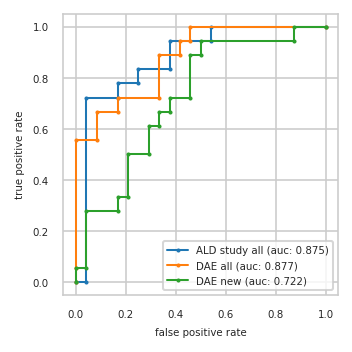

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.000 0.056
2          0.042 0.722   0.000 0.556   0.042 0.056
3          0.167 0.722   0.083 0.556   0.042 0.278
4          0.167 0.778   0.083 0.667   0.167 0.278
5          0.250 0.778   0.167 0.667   0.167 0.333
6          0.250 0.833   0.167 0.722   0.208 0.333
7          0.375 0.833   0.333 0.722   0.208 0.500
8          0.375 0.944   0.333 0.889   0.292 0.500
9          0.542 0.944   0.417 0.889   0.292 0.611
10         0.542 1.000   0.417 0.944   0.333 0.611
11         1.000 1.000   0.458 0.944   0.333 0.667
12           NaN   NaN   0.458 1.000   0.375 0.667
13           NaN   NaN   1.000 1.000   0.375 0.722
14           NaN   NaN     NaN   NaN   0.458 0.722
15           NaN   NaN     NaN   NaN   0.458 0.889
16           NaN   NaN     NaN   NaN   0.500 0.889
17           NaN   NaN     NaN   NaN   0.500 0.944
18           NaN   NaN     NaN   NaN   0.875 0.944
19           NaN   NaN     NaN   NaN   0.875 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,A6NFX8;Q9UKK9,B7Z5R6;Q14596;Q14596-2
2,P09486,E7EUF1;Q13822-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
3,K7ERG9;P00746,P04075,Q9NUQ9
4,P14174,Q9Y2T3;Q9Y2T3-3,P31321
5,P10636-2;P10636-6,P60709;P63261,P10644;P10644-2
6,P61981,P61981,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
7,Q9Y2T3;Q9Y2T3-3,Q14894,P51688
8,Q99983,P14174,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


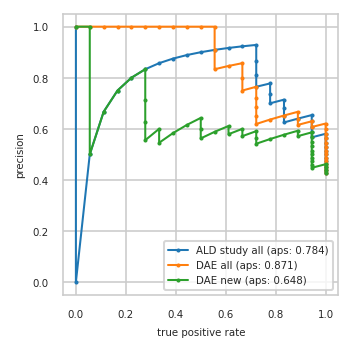

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.567 0.944     0.600 1.000     0.567 0.944
13         0.586 0.944     0.621 1.000     0.586 0.944
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.630 0.944     0.593 0.889
16         0.654 0.944     0.615 0.889     0.577 0.833
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.625 0.833     0.667 0.889     0.542 0.722
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.765 0.722     0.765 0.722     0.588 0.556
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.867 0.722     0.800 0.667     0.600 0.500
28         0.929 0.722     0.857 0.667     0.643 0.500
29         0.923 0.667     0.846 0.611     0.615 0.444
30         0.917 0.611     0.833 0.556     0.583 0.389
31         0.909 0.556     0.909 0.556     0.545 0.333
32         0.900 0.500     1.000 0.556     0.600 0.333
33         0.889 0.444     1.000 0.500     0.556 0.278
34         0.875 0.389     1.000 0.444     0.625 0.278
35         0.857 0.333     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.833 0.278
37         0.800 0.222     1.000 0.278     0.800 0.222
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


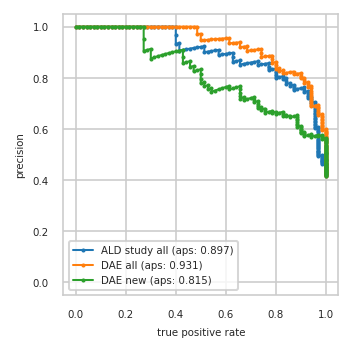

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


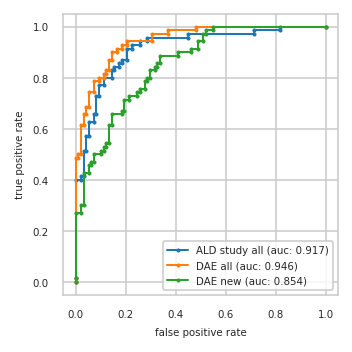

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}